In [ ]:
# Read text cations
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [ ]:
captions = readTextFile('drive/MyDrive/Image_captioning/captions.txt')
captions = captions.split("\n")[1:-1]
print(len(captions))

40455


In [ ]:
description = {}
for x in captions:
    # print(x)
    parts = x.split(',')
    img_name = parts[0][:-4]
    coment = parts[1]
    if description.get(img_name) is None:
        description[img_name] = []
    description[img_name].append(coment)

In [ ]:
# All libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.utils import load_img,img_to_array
from keras.models import Model,load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.layers.merging import add

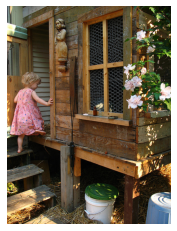

In [ ]:
img = cv2.imread("drive/MyDrive/Image_captioning/Images/1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
# Data cleaning
# Don't remove stopwords because we need to make meaningful words. Also stemming will also not applicable because we require texts has correct vocabulary
# Remove numbers, lower() , punctuations remove
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()

    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [ ]:
clean_text("A cat is sitting over the hk %lnolk ouse #number 64")

'cat is sitting over the hk lnolk ouse number'

In [ ]:
# clean all captions
for key,caption_list in description.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [ ]:
# Vocabulary
vocab = set()
for key in description.keys():
    [vocab.update(sentence.split()) for sentence in description[key]]
print(len(vocab))

8257


In [ ]:
# Total number of words across all the sentences
total_words = []
for key in description.keys():
    [total_words.append(i) for des in description[key] for i in des.split()]
print(len(total_words))

357791


In [ ]:
# Filter words from the vocab according to the certain threshold frequency
import collections
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
# print(freq_cnt)

In [ ]:
# Sort this dictionary according to freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filtering
threshold = 5
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
len(total_words)

2572

In [ ]:
# Prepare train/test data
train_filedata = readTextFile("drive/MyDrive/Image_captioning/Flickr_8k.trainImages.txt")
test_filedata = readTextFile("drive/MyDrive/Image_captioning/Flickr_8k.testImages.txt")

In [ ]:
train = [row.split(".")[0] for row in train_filedata.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_filedata.split("\n")[:-1]]

In [ ]:
# Prepare description for the training data
# Tweak - add <S> and <e> token to our training data
train_description = {}
for img_id in train:
    train_description[img_id] = []
    for cap in description[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_description[img_id].append(cap_to_append)

In [ ]:
train_description

{'2513260012_03d33305cf': ['startseq black dog is running after white dog in the snow endseq',
  'startseq black dog chasing brown dog through snow endseq',
  'startseq two dogs chase each other across the snowy ground endseq',
  'startseq two dogs play together in the snow endseq',
  'startseq two dogs running through low lying body of water endseq'],
 '2903617548_d3e38d7f88': ['startseq little baby plays croquet endseq',
  'startseq little girl plays croquet next to truck endseq',
  'startseq the child is playing croquette by the truck endseq',
  'startseq the kid is in front of car with put and ball endseq',
  'startseq the little boy is playing with croquet hammer and ball beside the car endseq'],
 '3338291921_fe7ae0c8f8': ['startseq brown dog in the snow has something hot pink in its mouth endseq',
  'startseq brown dog in the snow holding pink hat endseq',
  'startseq brown dog is holding pink shirt in the snow endseq',
  'startseq dog is carrying something pink in its mouth whil

In [ ]:
# Transfer learning
# Step 1. Image feature extraction
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
new_model = Model(model.input,model.layers[-2].output)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
def preprocess_img(img):
    img = load_img(img,target_size=(224,224))
    img = img_to_array(img)
    # print(img.shape)
    img = np.expand_dims(img,axis=0)
    # normalisation -> preprocess_input
    img = preprocess_input(img)
    return img

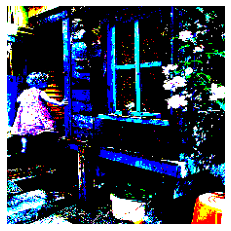

In [ ]:
# example
img = preprocess_img("drive/MyDrive/Image_captioning/Images/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [ ]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = new_model.predict(img,verbose=0)
    # print(feature_vector.shape)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [ ]:
# example
encode_image("drive/MyDrive/Image_captioning/Images/1000268201_693b08cb0e.jpg")

array([0.06535922, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [ ]:
# encode all train images
encoding_train = {}
# image_id --> feature vector extrcted from resnet
for ix,img_id in enumerate(train):
    img_path = "drive/MyDrive/Image_captioning/Images/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    if ix%100==0:
        print(ix)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900


In [ ]:
with open("drive/MyDrive/Image_captioning/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
# encode all test images
encoding_test = {}
# image_id --> feature vector extrcted from resnet
for ix,img_id in enumerate(test):
    img_path = "drive/MyDrive/Image_captioning/Images/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    if ix%100==0:
        print(ix)

0
100
200
300
400
500
600
700
800
900


In [ ]:
with open("drive/MyDrive/Image_captioning/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [ ]:
# Now retriving the picke saved dictionary
with open("drive/MyDrive/Image_captioning/encoded_train_features.pkl","rb") as f:
  encoding_train = pickle.load(f)
with open("drive/MyDrive/Image_captioning/encoded_test_features.pkl","rb") as f:
  encoding_test = pickle.load(f)

In [ ]:
encoding_train["2513260012_03d33305cf"]

array([0.3470795 , 0.51159084, 0.08728854, ..., 1.1897293 , 0.04043847,
       0.15271063], dtype=float32)

In [ ]:
# Data preprocessing -- captions
# Convert captions to numerical value

# Vocab
# len(total_words)

word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(total_words):
  word_to_idx[word] = i+1
  idx_to_word[i+1] = word

In [ ]:
# Two more words in dictionary startseq,endseq
word_to_idx['startseq'] = 2573
word_to_idx['endseq'] = 2574
idx_to_word[2573] = 'startseq'
idx_to_word[2574] = 'endseq'

len(word_to_idx.keys())

2574

In [ ]:
# Model training
# RNN model -> 
# Find max length of any caption to decide RNN model size
max_len=0
for key in train_description.keys():
  for cap in train_description[key]:
    max_len = max(max_len,len(cap.split())) 
print(max_len)

30


In [ ]:
# setting up as supervised learning problem (image captioning)
# y             =                f(x)
# caption                       image
# In image captioning we can't generate complete sentence at once
# Words are generated one by one
# The next words are generated according to the probabilty of already generated words

In [ ]:
# Data Loader(generator)
def data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size,vocab_size=2574):
  x1,x2,y = [],[],[]
  n=0

  while True:
    for key,desc_list in train_description.items():
      n+=1
      photo = encoding_train[key]
      for desc in desc_list:
        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx.keys()]
        for i in range(1,len(seq)):
          xi = seq[0:i]
          yi = seq[i]
          # print(yi)

          xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
          yi = to_categorical([yi-1],num_classes=vocab_size)[0]
          x1.append(photo)  # 2048
          x2.append(xi)     # 35 -> glove
          y.append(yi)      # vocab_size->2574

      if n==batch_size:
        yield [[np.array(x1),np.array(x2)],np.array(y)]
        x1,x2,y = [],[],[]
        n=0


In [ ]:
# WORD EMBEDDINGS
# The text data should be embedded before passing to RNN/LSTM layer
f = open("/content/drive/MyDrive/Image_captioning/glove.6B.50d.txt" , encoding='utf8')
embedding_index = {}

for line in f:
  values = line.split()
  # print(values)
  word = values[0]
  word_embedding = np.array(values[1:],dtype='float')
  embedding_index[word] = word_embedding


In [ ]:
def get_embedding_matrix(vocab_size=2574):
  emb_dim = 50
  matrix = np.zeros((vocab_size,emb_dim))
  for word,idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      matrix[idx] = embedding_vector
  return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(2574, 50)

In [ ]:
# Model ARCHITECTURE
# img feature -------->  MODEL --> Next word in sequence  ----
# partial sequence --->                                       |
#   | _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ |

# Partial caption ----> RNN 
#                           \
#                            \ Feed forward network ----> predicted word,next
#                            / ending with softmax        in the sequence of
#                           /                               partial caption
#               Image vector

# https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

In [ ]:
vocab_size = 2574
from keras.layers import Input
input_img_features = Input(shape=(2048,))
input_img1 = Dropout(0.3)(input_img_features)
input_img2 = Dense(256,activation="relu")(input_img1)

# Captions as input => batch_size*35 -> batch_size*35*50 -> 256
input_captions = Input(shape=(max_len,))
# Now here we use customize embedding and not the glove vector embedding yet
input_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
input_cap2 = Dropout(0.3)(input_cap1)
input_cap3 = LSTM(256)(input_cap2)

# Add inputs and decode them
decoder1 = add([input_img2,input_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# COMBINED MODEL
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 30, 50)       128700      ['input_13[0][0]']               
                                                                                                  
 dropout_9 (Dropout)            (None, 2048)         0           ['input_12[0][0]']               
                                                                                            

In [ ]:
# Important thing -- Embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss="categorical_crossentropy",optimizer="adam")
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 30, 50)       128700      ['input_13[0][0]']               
                                                                                                  
 dropout_9 (Dropout)            (None, 2048)         0           ['input_12[0][0]']               
                                                                                            

In [ ]:
# Training of Model
epochs = 10
batch_size = 3  # no if images per batch
steps = len(train_description)//batch_size
def train():
  for i in range(epochs):
    generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save("/content/drive/MyDrive/Image_captioning/models/"+str(i)+'.h5')

In [ ]:
train()

1999/1999 [==============================] - 614s 307ms/step - loss: 2.7687


In [ ]:
def predict_caption(photo):
  in_text = "startseq"
  for i in range(max_len):
    sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
    ypred = model.predict([photo,sequence])
    ypred = ypred.argmax()  # word with max probability -> greedy sampling
    word = idx_to_word[ypred+1]
    in_text += (' ' + word)
    if word=='endseq':
      break
  final_caption = in_text.split()[1:-1]
  final_caption = ' '.join(final_caption)
  return final_caption


1/1 [==============================] - 0s 27ms/step
man in yellow shirt is riding surfboard on the beach


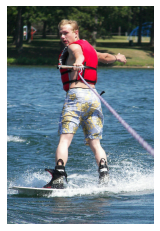

1/1 [==============================] - 0s 26ms/step
man in red shirt and white shorts is riding his bike on street


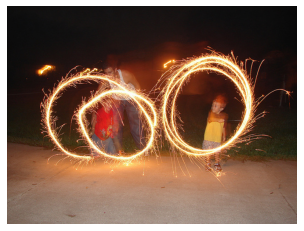

1/1 [==============================] - 0s 24ms/step
woman in sunglasses and sunglasses is wearing sunglasses


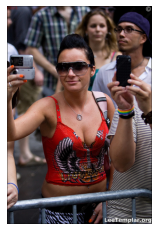

1/1 [==============================] - 0s 24ms/step
swimmer comes ready to catch water


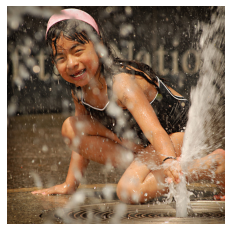

1/1 [==============================] - 0s 48ms/step
two dogs are running on beach


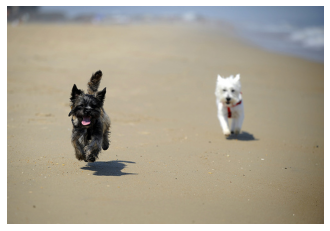

1/1 [==============================] - 0s 40ms/step
girl in white shirt and white shorts runs through the grass


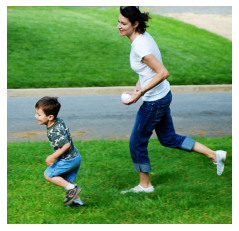

1/1 [==============================] - 0s 24ms/step
man in raincoat is riding on the beach


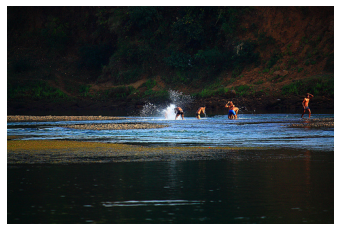

1/1 [==============================] - 0s 23ms/step
white dog is jumping over fence


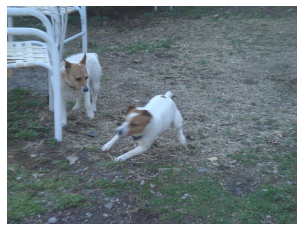

1/1 [==============================] - 0s 25ms/step
man in wetsuit is standing on the beach


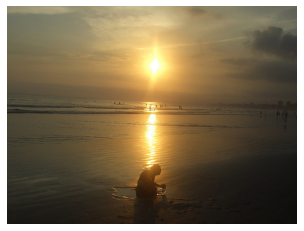

1/1 [==============================] - 0s 24ms/step
white dog with white collar is running in the snow


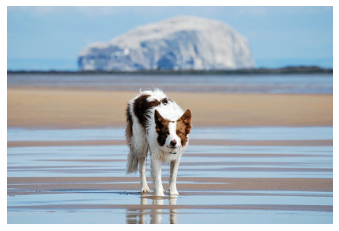

1/1 [==============================] - 0s 25ms/step
the hockey player in red uniform is challenging the player in red and white team


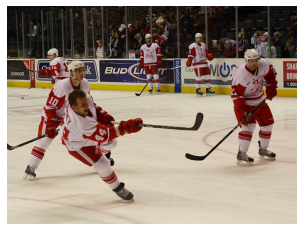

1/1 [==============================] - 0s 27ms/step
two men are standing in front of waterfall


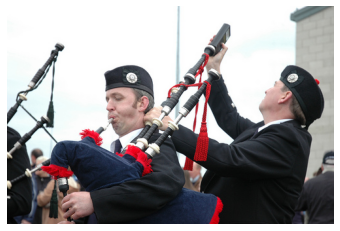

1/1 [==============================] - 0s 29ms/step
little girl in blue dress is sitting on the grass


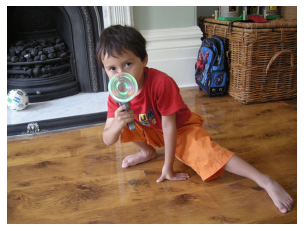

1/1 [==============================] - 0s 23ms/step
black dog is playing with red toy


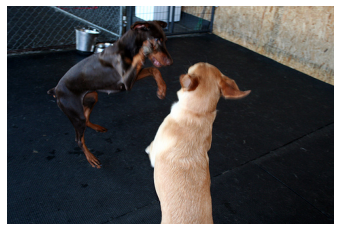

1/1 [==============================] - 0s 28ms/step
three men are sitting on rock with mountain


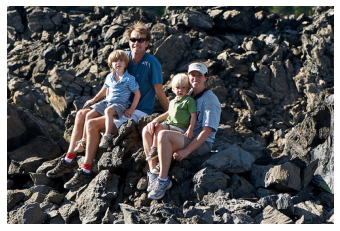

In [ ]:
# Pick some random images
for i in range(15):
  no = np.random.randint(0,1000)
  all_img_names = list(encoding_test.keys())
  img_name = all_img_names[no]
  photo_2048 = encoding_test[img_name].reshape((1,2048))

  caption = predict_caption(photo_2048)

  i = plt.imread("/content/drive/MyDrive/Image_captioning/Images/"+img_name+".jpg")
  print(caption)
  plt.imshow(i)
  plt.axis("off")
  plt.show()


In [ ]:
to_categorical([2574],num_classes=2575)

array([[0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
np.argmax([2,5,7])

2